# Lab2: Wall Following Robot

# 1. Import Wrapper 

In [1]:
import turtlebot4_wrapper
turtlebot4_wrapper.use_hardware()

# Load ROS library
import rclpy
if not rclpy.ok():
    rclpy.init()

# Instantiate Wrapper. The subscribes and publishes the relevant topics and connects the actions.
if not "robot" in globals():
    robot = turtlebot4_wrapper.Robot()

You are connected to uwbot-15
Robot is reachable


Could not determine the type for the passed topic


ros2 topic echo --once /ip failed. Proceed with caution.
ros2 topic subscription working. Everything is working as expected.


# 2. Record Data

In [3]:
robot.reset_odometry() # Make the robot think it is at position (0,0,0) 

In [4]:
robot.configure_logging(["/odom","/tf","/tf_static","/scan"]) # Set topics which should be recorded
robot.start_logging() # start the background logging process
logging_dir = robot.stop_logging()
log_data = robot.get_logging_data(logging_dir) # Parse the logged data and import in python

# 3. Plot 2D LiDAR points (Sliced)

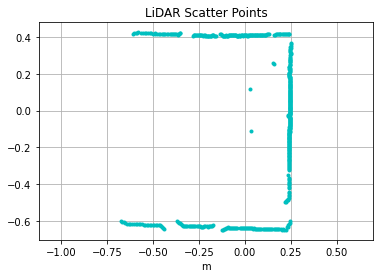

In [5]:
from matplotlib import pyplot as plt
import numpy 

# Static transform manually into T_base_lidar
T_base_lidar = numpy.array([[ 2.22044605e-16, -1.00000000e+00, -4.00000000e-02],
       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
 
def plot_lidar_scan_points():
    msg = robot.last_scan_msg
    pose = robot.last_odom_msg.pose.pose #Robot position from odometry (X)

    # Convert received lidar points from polar to cartesian coordinates considering the current position from odometry
    points = [(numpy.cos(angle)*radius,numpy.sin(angle)*radius) for angle, radius \
              in zip(numpy.linspace(msg.angle_min,msg.angle_max,len(msg.ranges)),msg.ranges)]

    T = robot.reduce_transform_to_2D(robot.convert_odom_to_transform(pose))
    
    # Remove points which cannot be measured
    filtered_points = filter(lambda x: numpy.isfinite(x).all(),points)
    
    # Display points in world frame (list)
    transformed_points = [numpy.matmul(numpy.dot(T,T_base_lidar),
        numpy.vstack([ numpy.atleast_2d(x).T,numpy.ones((1,1)) ]) ) for x in 
                          filtered_points]
    
    # Convert list to array (3D with shape n,3,1)
    tp_array = numpy.array(transformed_points) 

    # Reshape 3D array to 2D 
    twoD_array = tp_array.reshape(-1, 3)

    # Filter points within range (-1 to 1 meters)
    x_condition = (twoD_array[:,0] >= -1) & (twoD_array[:,0] <= 1) 
    y_condition = (twoD_array[:,1] >= -1) & (twoD_array[:,1] <= 1)
    within_range = (x_condition & y_condition) #mask
    sliced_array = twoD_array[within_range]

    fig, plot_points = plt.subplots() #Initialize plot as a 2D axes object
    plot_points.plot(sliced_array[:,0], sliced_array[:,1],'c.')
    # Formating
    plot_points.set_title("LiDAR Scatter Points")
    plot_points.set_xlabel("m")
    plot_points.grid()
    plot_points.axis('equal')
    
    return plot_points, sliced_array

pointPlot, pointArray = plot_lidar_scan_points() 

# 4. Clustering Data Points 
- DBSCAN (clustering) algorithm: https://www.reneshbedre.com/blog/dbscan-python.html#what-is-dbscan
- https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

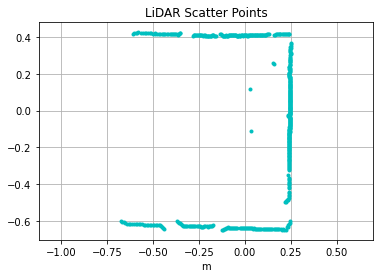

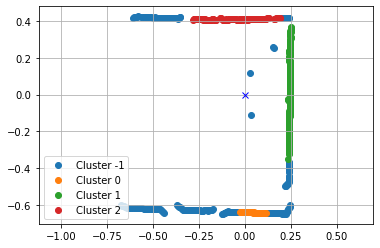

In [6]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def cluster(pointArray, eps=0.07, min_samples=25):
    # Display raw data: Odometry based position
    robot.odom_future = rclpy.Future()
    pose = robot.spin_until_future_completed(robot.odom_future).pose.pose

    # DBSCAN to cluster points
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(pointArray)  # Assigns a cluster_id to each value in pointArray
    unique_clusters = np.unique(clusters) # Identifies the number of cluster_ids assigned
    cluster_data={} #Dictionary with the points for each cluster

    fig, plot_clusters = plt.subplots()
    for cluster_id in unique_clusters:
        cluster_mask = (clusters == cluster_id) #Array with True indexes
        cluster_points = pointArray[cluster_mask] #Array with values in True indexes 
        cluster_data[cluster_id] = cluster_points #Store clusters in a dictionary
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

    plot_clusters.plot(pose.position.x, pose.position.y, 'bx')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.axis('equal')

    return cluster_data, plot_clusters

pointPlot, pointArray = plot_lidar_scan_points() 

cluster_data, plot_clusters = cluster(pointArray)

# 5. Show Robot's orientation
- Converted Quaternion to Euler Angle: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html

0.024147342291110093

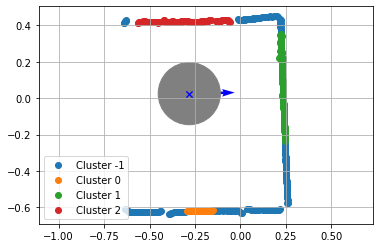

In [37]:
from scipy.spatial.transform import Rotation as R 
import matplotlib.pyplot as plt
import numpy as np 
         
def quaternion_to_list(q):
    return [q.x, q.y, q.z, q.w]

def showOrientation(plot2D):
    # Display raw data: Odometry based position
    robot.odom_future = rclpy.Future()
    pose = robot.spin_until_future_completed(robot.odom_future).pose.pose

    # Convert quaternions to Euler to obtain the rotation in the z-axis (yaw)
    oriQuat = quaternion_to_list (pose.orientation)
    x, y =  pose.position.x, pose.position.y
    r = R.from_quat(oriQuat)
    OriEuler = r.as_euler('xyz', degrees=False)
    yaw = OriEuler[2]

    #Parametrization of the yaw angle in x-y 
    magnitude = 0.25
    arrow_x = magnitude * np.cos(yaw)
    arrow_y = magnitude * np.sin(yaw) 

    #Plot arrow in my previous plot
    plot2D.plot(pose.position.x, pose.position.y, 'bx')
    plot2D.quiver(x, y, arrow_x, arrow_y, color='b', angles ='xy', scale_units ='xy', 
                  scale=1, label='Robot Orientation')
    
    #Show robot's body
    robotBody = plt.Circle((pose.position.x, pose.position.y), radius= 0.171, color='gray') #Diameter = 342 mm
    plot2D.add_patch(robotBody)
    
    return yaw
    
cluster_data, plot_clusters = cluster(pointArray)

showOrientation(plot_clusters)

# 6. Identify Main Wall (Fit a line on a group of points)
- Useful: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html
- RANSACRegression algorithm: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html

0.024145481845971078

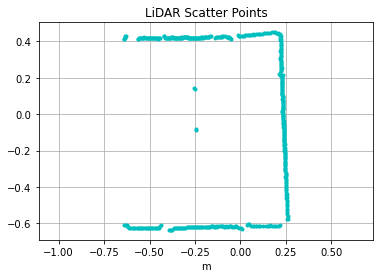

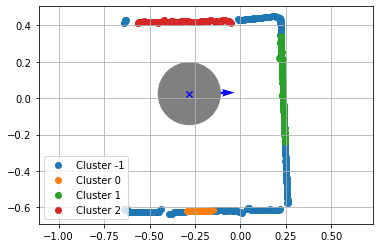

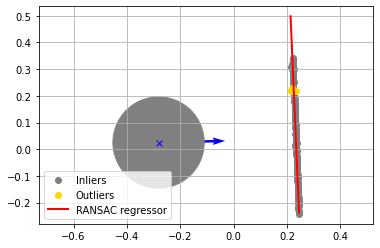

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

def lineFitting(cluster_data):
    # Get information from cluster
    mainWall = cluster_data[1] #Modify to change wall
    x = mainWall[:,0].reshape(-1,1)
    y = mainWall[:,1].reshape(-1,1)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(x, y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    # Predict data of estimated models 
    line_X = np.linspace(x.min(), x.max(), 100)[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)

    #Obtain equation of the line 
    slope = ransac.estimator_.coef_[0]
    y_intercept = ransac.estimator_.intercept_
    
    fig, plot_wall = plt.subplots()
    #Plot cluster points
    plot_wall.scatter(x[inlier_mask], y[inlier_mask], c='gray', label=f"Inliers")
    plot_wall.scatter(x[outlier_mask], y[outlier_mask], c='gold', label=f"Outliers")
    #Plot RANSAC regression line
    plot_wall.plot(line_X, line_y_ransac, 'r', linewidth =2, label=f"RANSAC regressor")
    plt.legend(loc="lower left")
    plt.grid()
    plt.axis('equal')

    return plot_wall, slope, y_intercept

pointPlot, pointArray = plot_lidar_scan_points() 
cluster_data, plot_clusters = cluster(pointArray)
showOrientation(plot_clusters)
plot_wall, slope, y_intercept = lineFitting(cluster_data)
showOrientation(plot_wall)

# 7. Compare distance between point and line

Distance 1:  [0.39004042]


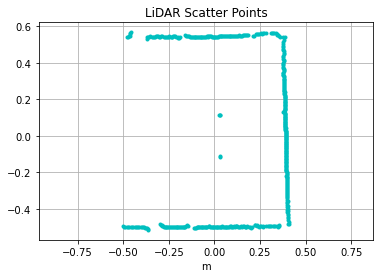

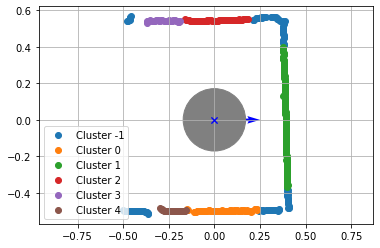

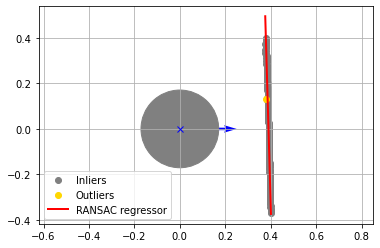

In [55]:
import numpy as np

def distance(slope, y_intercept, desired_distance = 0.35):
     robot.reset_odometry() # Make the robot think it is at position (0,0,0) 
     
     #while True: 
     #Check if robot orientation wrt to line? -> Check cluster to the one faced by the robot.  
     #Assume robot is always facing the line (Cluster 1) and it's docked
     #robot.undock()
     #Quarter revolution
     #robot.set_cmd_vel(0.0, 0.5, 3.14)
     #Move away
     #robot.set_cmd_vel(0.1, 0.0, 2.0)

     #Get robot's current position
     robot.odom_future = rclpy.Future() 
     pose1 = robot.spin_until_future_completed(robot.odom_future).pose.pose
     position1 = np.array([pose1.position.x, pose1.position.y])
     
     
     #Calculate perpendicular distance from robot position to line (wall)
     dist1 = np.abs(slope*position1[0] - position1[1] + y_intercept) / np.sqrt(slope**2 + 1)
     print('Distance 1: ', dist1)

     #Calculate error
     #error1 = desired_distance - dist1
     #print(error1)
     
     #if dist1 < desired_distance: 
          #Half revolution
          #robot.set_cmd_vel(0.0, -0.5, 3.14)
     #elif dist1 > desired_distance:
          #robot.set_cmd_vel(0.0, 0.5, 3.14)
     #robot.set_cmd_vel(0.1, 0.0, np.abs(error1)/0.1)

     #Get robot's current position
     #robot.odom_future = rclpy.Future() 
     #pose2 = robot.spin_until_future_completed(robot.odom_future).pose.pose
     #position2 = np.array([pose2.position.x, pose2.position.y])
    
     #Check distance again after the movement
     #dist2 = np.abs(slope*position2[0] - position2[1] + y_intercept) / np.sqrt(slope**2 +1)
     #print('Distance 2: ', dist2)
     
     #error2 = desired_distance - dist2
     #print(error2)

pointPlot, pointArray = plot_lidar_scan_points() 
cluster_data, plot_clusters = cluster(pointArray)
showOrientation(plot_clusters)
plot_wall, slope, y_intercept = lineFitting(cluster_data)
showOrientation(plot_wall)
distance(slope, y_intercept)


# 8.Compare robot's orientation with line orientation 
- Assume robot faces wall.
- Error: cluster changes as I move.

[1.13876979]
-2.569375044890821
[3.70814484]


1.1453514055992267

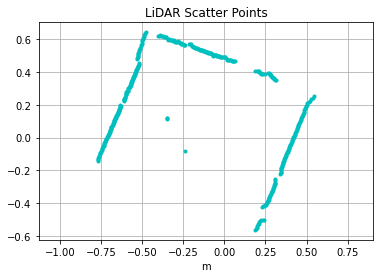

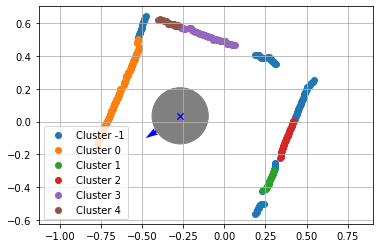

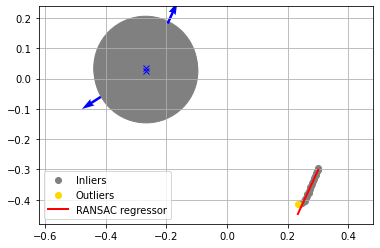

In [48]:
import numpy as np 
from matplotlib import pyplot as plt

def compare_orientation(slope, yaw):
    angle_line = np.arctan(slope)

    # error (in radians)
    error = np.abs(angle_line - yaw)

    robot.set_cmd_vel(0.0, 0.5, error/0.5)

plot_wall, slope, y_intercept = lineFitting(cluster_data)
yaw = showOrientation(plot_wall)
compare_orientation(slope, yaw)
